In [1]:
import sqlite3 as db 
import pandas as pd
conn = db.connect('soccer/database.sqlite')


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [2]:
norm_team_name = {}
norm_team_name['Man United'] = 'Manchester United'
norm_team_name['Man City'] = 'Manchester City'
norm_team_name['QPR'] = 'Queens Park Rangers'
norm_team_name['West Brom'] = 'West Bromwich Albion'
norm_team_name['West Ham'] = 'West Ham United'
norm_team_name['Bournemouth'] = 'AFC Bournemouth'

year_data = {'2014': 'statbunker-football-stats/Player Stats 2014-15.csv' , 
             '2015': 'statbunker-football-stats/Player Stats 2015-16.csv' ,
             '2016': 'statbunker-football-stats/Player Stats 2016-17.csv'}


In [3]:
def get_all_players_info(year):
    query_str = """select  p.player_name,pa2.* from player_attributes pa2, player p where p.player_api_id = pa2.player_api_id and
    (pa2.player_api_id, pa2.date) in (
    select z.player_api_id, z.date from (
    select pa.player_api_id, pa.date, min(abs(strftime('%%s',pa.date) - strftime('%%s','%(year)s-09-01 00:00:00'))) from player_attributes pa, player p 
                                    where pa.player_api_id = p.player_api_id
                                    and strftime('%%s',pa.date) > strftime('%%s','2014-05-14 00:00:00') 
                                    and pa.date like '%(year)s%%'
                                    group by pa.player_api_id ) z )"""%{'year':year}
    
    all_player_attrs = pd.read_sql_query(query_str,conn)
    
    return all_player_attrs


In [4]:
def norm_player_names(all_players_info):
    
    for key,value in norm_team_name.items():
        all_players_info.loc[lambda df: df['HomeTeam'] == key, 'HomeTeam'] = value
        all_players_info.loc[lambda df: df['AwayTeam'] == key, 'AwayTeam'] = value
    
    return all_players_info

In [5]:
def get_full_data(year):
    ptm = pd.read_csv(year_data[year] , dtype = {'overall_rating':float} )
   
    ptm = ptm[(ptm['Type Of Goal'] == 'Player') & (ptm['League'] == 'Premier League')]
    
    all_players_info  = get_all_players_info(year)
        
    joined = all_players_info.set_index('player_name').join(ptm.set_index('Player'), how='inner')
    return joined

In [6]:
def create_team(data, name):
    
    full_team = data[data['Team'].str.startswith(name)]
        
    team_agg = {}
    
    team_df = {}
    
    df_start = full_team[full_team['Team'] == 'THIS DOES NOT EXIST']
    
    pos_sel = {'Defender': 4, 'Midfielder': 4, 'Forward': 2, 'Goalkeeper':1}

    
    
#     if (len(df_start[df_start['Position'] == 'Forward']) < 3 ):
#         forwards = len(df_start[df_start['Position'] == 'Forward'])
#         print(forwards)
#         pos_sel['Forward'] = forwards
#         pos_sel['Midfielder'] = 6 - forwards

    for key,value in pos_sel.items():
        
        grp = full_team[full_team['Position'] == key].sort_values(by = ['overall_rating'], ascending = False).head(value)
        df_start = df_start.append(grp)
        avg = grp.mean()
        team_agg[key] = avg
    
    return df_start

In [7]:
def agg_attributes(team):
    #team[team['Position'] == 'Goalkeeper']['Position'] = 'Defender'
    
    team.loc[lambda df: df['Position'] == 'Goalkeeper', 'Position'] = 'Defender'
       
    
    g = team.groupby(['Position'] , as_index=False).mean()
    #print(g['overall_rating'])
    #g = g.reset_index().set_index('index')
    
    return g.transpose()

In [8]:
def get_fixtures(year):
    f = pd.read_csv('epl-results-19932018/EPL_Set.csv')
    f = norm_player_names(f)
    
    return f[f['Season'].str.startswith(year)]
    


In [9]:
def combine_metrics_2(home_attrs,away_attrs,i):
    ### D - D , A - A ###
    norm_attrs = {}
    norm_attrs['Home_Def'] = home_attrs[0]['overall_rating']
    norm_attrs['Home_Att'] = home_attrs[2]['overall_rating']
    norm_attrs['Home_Mid'] = home_attrs[1]['overall_rating']
    
    norm_attrs['Away_Def'] = away_attrs[0]['overall_rating']
    norm_attrs['Away_Att'] = away_attrs[2]['overall_rating']
    norm_attrs['Away_Mid'] = away_attrs[1]['overall_rating']

    norm_attrs['Def_Score'] = home_attrs[0]['overall_rating'] - away_attrs[0]['overall_rating']
    norm_attrs['Mid_Score'] = home_attrs[2]['overall_rating'] - away_attrs[2]['overall_rating']
    norm_attrs['Att_Score'] = home_attrs[1]['overall_rating'] - away_attrs[1]['overall_rating']
    norm_attrs['Result'] = 1 if row['FTHG'] - row['FTAG'] > 0  else (-1 if row['FTHG'] - row['FTAG'] < 0 else 0)
    
    norm_df = pd.DataFrame(norm_attrs, index = [str(i)])
    
    return norm_df

def combine_metrics_1(home_attrs,away_attrs,i):
    """ D-A  """
    norm_attrs = {}
    
    norm_attrs['Home_Def'] = home_attrs[0]['overall_rating']
    norm_attrs['Home_Att'] = home_attrs[2]['overall_rating']
    norm_attrs['Home_Mid'] = home_attrs[1]['overall_rating']
    
    norm_attrs['Away_Def'] = away_attrs[0]['overall_rating']
    norm_attrs['Away_Att'] = away_attrs[2]['overall_rating']
    norm_attrs['Away_Mid'] = away_attrs[1]['overall_rating']
    
    norm_attrs['Def_Score'] = home_attrs[0]['overall_rating'] - away_attrs[1]['overall_rating']
    norm_attrs['Mid_Score'] = home_attrs[2]['overall_rating'] - away_attrs[2]['overall_rating']
    norm_attrs['Att_Score'] = home_attrs[1]['overall_rating'] - away_attrs[0]['overall_rating']
    norm_attrs['Result'] = 1 if row['FTHG'] - row['FTAG'] > 0  else (-1 if row['FTHG'] - row['FTAG'] < 0 else 0)
    
    norm_df = pd.DataFrame(norm_attrs, index = [str(i)])
    
    return norm_df

In [10]:
def get_all_team_data(year):
    
    data = {}

    joined_data = get_full_data(year)

    f = get_fixtures(year)
    teams = f['HomeTeam'].unique()

    for team in teams:
        team_data = create_team(joined_data, team)
        team_attr = agg_attributes(team_data)
        data[team] = (team_data, team_attr)

    return data

In [11]:
def attr_normalize(df, attr,column):
        
    mx = max(df[column])
    mn = min(df[column])
    diff = (mx) - (mn)

    df[attr] = df[attr].apply(lambda x : x/diff)
    return df[attr]

In [12]:
team_store = get_all_team_data('2016')

j = get_full_data('2016')


In [13]:
from matplotlib import pyplot as plt

i = 0
res_df = pd.DataFrame()
f = get_fixtures('2016')
for key,row in f.iterrows():
#     print("MATCHING UP: %s vs %s"%(row['HomeTeam'], row['AwayTeam']))
    home = row['HomeTeam']
    away = row['AwayTeam']
    
    home_attrs = team_store[home][1]
    away_attrs = team_store[away][1]

    res_df = res_df.append(combine_metrics_2(home_attrs,away_attrs,i))
    
    i = i + 1
    

In [14]:

res_df['Att_Score'] = attr_normalize(res_df, 'Att_Score','Home_Att' )
res_df['Def_Score'] = attr_normalize(res_df, 'Def_Score','Home_Def' )
res_df['Mid_Score'] = attr_normalize(res_df, 'Mid_Score','Home_Mid' )

res_df.pop('Home_Att')
res_df.pop('Home_Mid')
res_df.pop('Home_Def')
res_df.pop('Away_Att')
res_df.pop('Away_Mid')
d = res_df.pop('Away_Def')


# number of times the stronger team has won against the weaker team

In [15]:
print(res_df)

     Att_Score  Def_Score  Mid_Score  Result
0    -0.363636  -0.309091  -0.141026      -1
1     1.318182   0.418182   0.012821      -1
2     0.000000  -0.654545  -0.076923       0
3    -0.590909  -0.236364  -0.064103       1
4     0.590909   0.836364   0.371795       1
5    -0.272727  -0.272727  -0.179487       0
6     0.000000   0.254545   0.153846       0
7     0.727273   0.727273   0.025641      -1
8    -0.545455  -0.886364  -0.525641      -1
9     0.272727   0.236364   0.205128       1
10   -0.045455   0.327273   0.384615       1
11   -0.409091  -0.218182  -0.346154       1
12   -0.409091  -0.454545  -0.243590       0
13   -0.454545  -0.509091  -0.269231      -1
14    0.227273   0.054545   0.076923      -1
15   -0.045455   0.272727   0.192308       1
16   -0.409091  -0.418182  -0.564103      -1
17   -1.272727  -0.036364  -0.128205      -1
18    0.136364  -0.054545   0.076923      -1
19    0.727273   0.486364   0.346154       1
20    0.954545   0.745455   0.487179       1
21    0.81

0.4921052631578947
0.22105263157894736
0.2868421052631579
0.22105263157894736
0.2868421052631579
0.48157894736842105


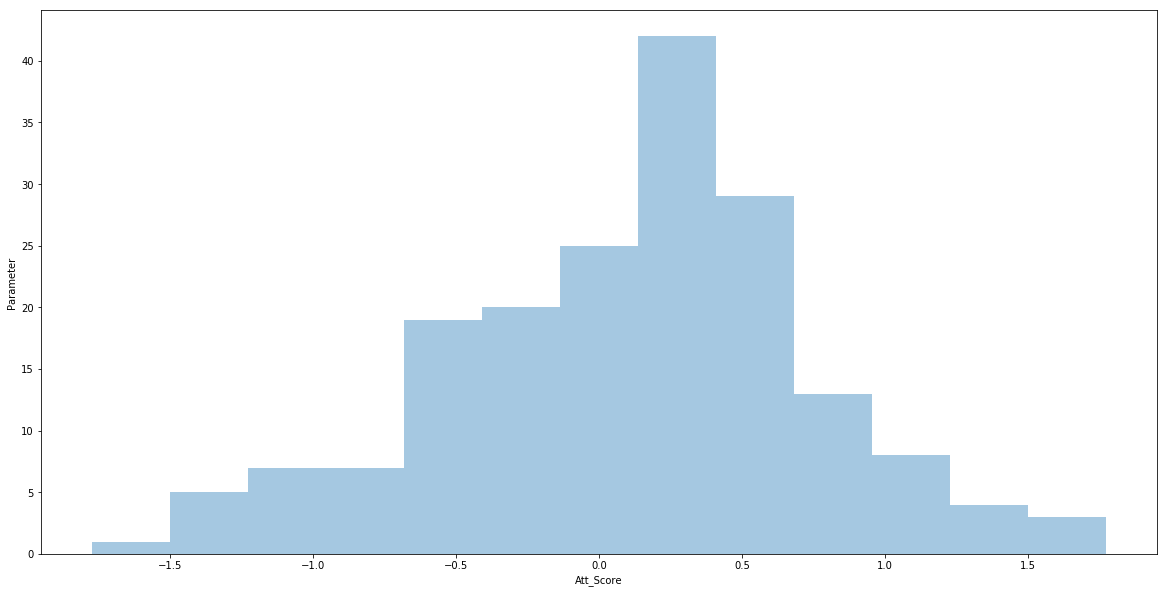

In [16]:
import seaborn as sns


plt.figure(figsize = (20,10))
plt.xlabel('Games')
plt.ylabel('Parameter')

strong_winners = res_df[(res_df['Att_Score'] > 0) & (res_df['Result'] == 1)].append(res_df[(res_df['Def_Score'] < 0) & (res_df['Result'] == -1)])

weak_winners = res_df[(res_df['Att_Score'] < 0) & (res_df['Result'] == 1)].append(res_df[(res_df['Def_Score'] > 0) & (res_df['Result'] == -1)])


plt.subplot()
sns.distplot(strong_winners['Att_Score'], norm_hist = False, kde = False)

# for key, row in res_df.iterrows():
    
#     if (row['Def_Score'] > 0 and row['Result'] == 1) or (row['Def_Score'] < 0 and row['Result'] == -1):
#         color = ''
        
#     elif row['Result'] == 0:
#         color = ''
#     else:
#         color = 'bx'
 
#     plt.plot(key, row['Att_Score'], color)

# plt.show()
# attr = ['Att_Score','Def_Score','Mid_Score']




# for a in enumerate(attr):
#     print("Based on attribute %s"%a)
#     strong_winners_home = res_df[(res_df[a] > 0) & (res_df['Result'] == 1)]
#     strong_winners_away = res_df[(res_df[a] < 0) & (res_df['Result'] == -1)]

    
#     plt.plot(i,res_df['Att_Score'],'bo',label = 'Test')
#     strong_draw_home = res_df[(res_df[a] > 0) & (res_df['Result'] == 0)]
#     strong_draw_away = res_df[(res_df[a] < 0) & (res_df['Result'] == 0)]
    
#     weak_winner_home = res_df[(res_df[a] > 0) & (res_df['Result'] == -1)]
#     weak_winner_away = res_df[(res_df[a] < 0) & (res_df['Result'] == 1)]
 
# #     print(len(strong_winners_away) + len(strong_winners_home) )

# #     #print(strong_winners_home
# #     print(len(strong_draw_home) + len(strong_draw_away))
    
# #     print(len(weak_winner_away) + len(weak_winner_home) )
    
    
# #plt.show()

In [17]:
import keras
print(keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Activation

D:\Apps\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


2.2.4


In [18]:
def create_model(x_train,y_train):
  """ Creates a Sequential model made out of Densely connected Neural Network layers. All parameters are configured as per specification for Q4"""
  
  model = Sequential()
  #Input Layer with 61 inputs corresponding to 61 features 
  model.add(Dense(10,input_dim = 3, activation = 'relu'))
  
  model.add(Dense(1,activation = 'sigmoid'))
  
  #Compiling the model with appropriate parameters
  model.compile(loss = 'mse', optimizer ='sgd',metrics = ['accuracy'])
  
  result = model.fit(x_train,y_train,epochs = 5, batch_size = 50)
  
  #Store the model, its average training accuracy and validation accuracy over 10 epochs
  
  return model


In [19]:
from sklearn.model_selection import train_test_split

full_copy = res_df.copy()
print(full_copy)
#full_copy = full_copy[full_copy['Result'] !=0]
#full_copy[full_copy['Result'] == 1]
# print(full_copy[full_copy['Result'] == 1])
# print(full_copy[full_copy['Result'] == 0])
# print(full_copy[full_copy['Result'] == -1])

full_y = full_copy.pop('Result')
full_x = full_copy

# tr_data = full_copy.iloc[:300]
# te_data =  full_copy.iloc[300:381]

x_train,te_x,y_train,te_y = train_test_split(full_x, full_y, test_size = 0.25, stratify = full_y)


# y_train = tr_data.pop('Result')
# x_train = tr_data

# te_y = te_data.pop('Result')
# te_x = te_data


     Att_Score  Def_Score  Mid_Score  Result
0    -0.363636  -0.309091  -0.141026      -1
1     1.318182   0.418182   0.012821      -1
2     0.000000  -0.654545  -0.076923       0
3    -0.590909  -0.236364  -0.064103       1
4     0.590909   0.836364   0.371795       1
5    -0.272727  -0.272727  -0.179487       0
6     0.000000   0.254545   0.153846       0
7     0.727273   0.727273   0.025641      -1
8    -0.545455  -0.886364  -0.525641      -1
9     0.272727   0.236364   0.205128       1
10   -0.045455   0.327273   0.384615       1
11   -0.409091  -0.218182  -0.346154       1
12   -0.409091  -0.454545  -0.243590       0
13   -0.454545  -0.509091  -0.269231      -1
14    0.227273   0.054545   0.076923      -1
15   -0.045455   0.272727   0.192308       1
16   -0.409091  -0.418182  -0.564103      -1
17   -1.272727  -0.036364  -0.128205      -1
18    0.136364  -0.054545   0.076923      -1
19    0.727273   0.486364   0.346154       1
20    0.954545   0.745455   0.487179       1
21    0.81

In [25]:
#Training neural network

model = create_model(x_train,y_train)
#pred_y = model.predict(te_x)
score = model.evaluate(te_x,te_y)


Epoch 1/5
285/285 [==============================] - 0s 406us/step - loss: 0.8584 - acc: 0.4877
Epoch 2/5
285/285 [==============================] - 0s 28us/step - loss: 0.8556 - acc: 0.4842
Epoch 3/5
285/285 [==============================] - 0s 42us/step - loss: 0.8530 - acc: 0.4737
Epoch 4/5
285/285 [==============================] - 0s 42us/step - loss: 0.8505 - acc: 0.4702
Epoch 5/5
95/95 [==============================] - 0s 336us/step


In [26]:
#Training SVM

In [29]:
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score

svm = LinearSVC(C = 0.1)


svm.fit(x_train,y_train)
# print(svm.coef_)
# print(svm.intercept_)
y_pred = svm.predict(te_x)
print(y_pred)
z =accuracy_score(te_y,y_pred)
print(z)

[ 1  1 -1 -1  1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1 -1  1  1  1  1 -1  1  1  1  1 -1  1  1  1 -1  1  1 -1  1 -1  1
 -1  1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1  1 -1 -1 -1  1 -1  1  1  1
 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1 -1 -1  1 -1]
0.5894736842105263


In [28]:
#Training decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 8, random_state = 5)

dt.fit(x_train['Att_Score'].values.reshape(-1,1),y_train)

y_pred = dt.predict(te_x['Att_Score'].values.reshape(-1,1))

a = accuracy_score(te_y,y_pred)
print(a)
# print(te_y.values)
print(y_pred)

confusion_matrix(y_pred, te_y, labels = [1,0,-1])

# import graphviz 


# dot_data = tree.export_graphviz(dt, out_file='test',feature_names = ['Att_Score'] ,class_names = ['0','-1','1'])

# graphviz.render('dot','png','test', quiet = False)

0.4421052631578947
[ 1  1  1  1 -1  1  1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1  1  1  0  1  0
  1 -1  1  1  1  1 -1  1  1 -1  0  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1 -1  1  0 -1 -1  1  1  0  1  1  1  1  1  1  1 -1 -1 -1 -1 -1  1  1
  1  1 -1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1  1  1  1 -1  1  1]


array([[30, 17, 16],
       [ 2,  2,  1],
       [15,  2, 10]], dtype=int64)